# Call model

In [14]:
import os
import sys
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [15]:
class SimpleNN(nn.Module):
    def __init__(self, input_size=4*3, hidden_size=8*3, num_layers=2):
        super(SimpleNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

    def forward(self, x):
        x = x.flatten(2) # (N, T, 12)
        out, _ = self.lstm(x) # (N, T, 24)
        return out

In [16]:
model = SimpleNN(input_size=4*3, hidden_size=8*3, num_layers=2)  # 네가 썼던 모델 구조랑 똑같이 만들어야 해

model.load_state_dict(torch.load('./LSTM_epoch_1.pth'))

model.eval()

SimpleNN(
  (lstm): LSTM(12, 24, num_layers=2, batch_first=True)
)

# Heatmap Across Joints

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_joint_error_heatmap(pred, gt, save_path=None):
    """
    Plot heatmap of MPJPE error per joint averaged over time.
    
    Args:
        pred: (T, J, 3) predicted skeletons
        gt: (T, J, 3) ground-truth skeletons
        save_path: optional path to save the figure
    """
    errors = np.linalg.norm(pred - gt, axis=-1)  # (T, J)
    mean_errors = errors.mean(axis=0)  # (J,)

    fig, ax = plt.subplots(figsize=(8, 4))
    heatmap = ax.imshow(mean_errors[np.newaxis, :], cmap='Reds', aspect='auto')

    ax.set_xlabel('Joint Index')
    ax.set_yticks([])
    ax.set_title('Mean Joint Errors (MPJPE)')

    # Add colorbar
    cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical')
    cbar.set_label('Error (meters)', rotation=270, labelpad=15)

    if save_path:
        plt.savefig(save_path)
    plt.show()


# Heatmap Across Frames

In [18]:
def plot_frame_error_heatmap(pred, gt, save_path=None):
    """
    Plot heatmap of MPJPE error per frame averaged over joints.
    
    Args:
        pred: (T, J, 3) predicted skeletons
        gt: (T, J, 3) ground-truth skeletons
        save_path: optional path to save the figure
    """
    errors = np.linalg.norm(pred - gt, axis=-1)  # (T, J)
    mean_errors = errors.mean(axis=1)  # (T,)

    fig, ax = plt.subplots(figsize=(8, 4))
    heatmap = ax.imshow(mean_errors[:, np.newaxis].T, cmap='Blues', aspect='auto')

    ax.set_ylabel('Error')
    ax.set_xticks(np.arange(0, len(mean_errors), max(len(mean_errors)//10, 1)))
    ax.set_xlabel('Frame Index')
    ax.set_title('Mean Frame Errors (MPJPE)')

    # Add colorbar
    cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical')
    cbar.set_label('Error (meters)', rotation=270, labelpad=15)

    if save_path:
        plt.savefig(save_path)
    plt.show()


In [19]:
import os
import sys
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        data = np.load(filename)
        time, torso, left_arm, right_arm = extractMoCap(data)
        time, left_acc, right_acc, left_gyro, right_gyro = extractIMU(data)

        mocap = np.concatenate([left_arm, right_arm], axis=1) # (T, 8, 3)
        imu = np.stack([left_acc, right_acc, left_gyro, right_gyro], axis=1) # (T, 4, 3)

        return {'time': torch.tensor(time, dtype=torch.float32),
                'mocap': torch.tensor(mocap, dtype=torch.float32),
                'imu': torch.tensor(imu, dtype=torch.float32)}

def extractMoCap(data):
    time = data['time'] # (T,)
    torso = np.stack([np.zeros_like(data['leftShoulderPosRel']),
                      data['leftShoulderPosRel'],
                      data['rightShoulderPosRel'],
                      np.zeros_like(data['rightShoulderPosRel'])], axis=1) # (T, 4, 3)
    left_arm = np.stack([data['leftShoulderPosRel'],
                         data['leftElbowPosRel'],
                         data['leftWristPosRel'],
                         data['leftFingerPosRel']], axis=1) # (T, 4, 3)
    right_arm = np.stack([data['rightShoulderPosRel'],
                          data['rightElbowPosRel'],
                          data['rightWristPosRel'],
                          data['rightFingerPosRel']], axis=1) # (T, 4, 3)

    return time, torso, left_arm, right_arm

def extractIMU(data):
    time = data['time'] # (T,)
    left_acc = data['accelerationLeftLoc'] # (T, 3)
    right_acc = data['accelerationRightLoc'] # (T, 3)
    left_gyro = data['gyroLeftLoc'] # (T, 3)
    right_gyro = data['gyroRightLoc'] # (T, 3)

    return time, left_acc, right_acc, left_gyro, right_gyro
 
filenames = glob.glob('../data/*.npz')
assert len(filenames) > 0, 'No data files found in ./data/'

filename = filenames[0]
data = np.load(filename)

subjects = np.unique([f.split('_')[-2] for f in filenames])


np.random.seed(42)  # Fix random seed

permutation = np.random.permutation(len(subjects))
train_subjects = subjects[permutation[:-1]]
test_subjects = subjects[permutation[-1:]]

print(f'Training on subjects: {train_subjects}')
print(f'Testing on subjects: {test_subjects}')

train_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in train_subjects)])
test_dataset = CustomDataset([f for f in filenames if any(s == f.split('_')[-2] for s in test_subjects)])

Training on subjects: ['s8' 's10' 's5' 's1' 's7' 's2' 's9' 's4' 's3']
Testing on subjects: ['s6']


In [23]:
import torch
from torch.utils.data import DataLoader

def collate_fn(batch):
    longest_sample = max(batch, key=lambda x: len(x['time']))
    max_len = len(longest_sample['time']) # max_len
    padded_batch = []

    for sample in batch:
        padding_len = max_len - len(sample['time'])
        padded_sample = {}
        padded_sample['mocap'] = torch.cat([sample['mocap'],
                                            sample['mocap'][-1:].repeat(padding_len,1,1)]) # (max_len, 8, 3)
        acc = torch.cat([sample['imu'][:,[0,1]],
                         sample['imu'][-1:,[0,1]].repeat(padding_len,1,1)]) # (max_len, 2, 3)
        gyro = torch.cat([sample['imu'][:,[2,3]],
                          torch.zeros_like(sample['imu'][-1:,[2,3]]).repeat(padding_len,1,1)]) # (max_len, 2, 3)
        padded_sample['imu'] = torch.cat([acc, gyro], dim=1) # (max_len, 4, 3)
        padded_batch.append(padded_sample)

    return {'time': longest_sample['time'],
            'mocap': torch.stack([sample['mocap'] for sample in padded_batch]),
            'imu': torch.stack([sample['imu'] for sample in padded_batch])}

batch_size = 10
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn)
device = model.lstm.weight_ih_l0.device      # 모델과 같은 디바이스

# ── 1. 배치 하나 꺼내기 ─────────────────────────────
batch = next(iter(test_dataloader))          # dict 하나
inputs = batch['imu'].to(device)             # (B, T, 4, 3)
gt_full = batch['mocap'].to(device)          # (B, T, 8, 3)

# ── 2. 추론 ────────────────────────────────────────
with torch.no_grad():
    outputs = model(inputs)                  # (B, T, 8, 3) – decoder 포함 모델이면 바로 OK
                                             # decoder 없으면 view/linear 추가 필요

# ── 3. numpy 변환 & 한 시퀀스만 선택 ───────────────
pred = outputs[0].cpu().numpy()              # (T, 8, 3)
gt   = gt_full[0].cpu().numpy()              # (T, 8, 3)

# ── 4. 시각화 ──────────────────────────────────────
plot_joint_error_heatmap(pred, gt, save_path='./result/joint_error_heatmap.png')
plot_frame_error_heatmap(pred, gt, save_path='./result/frame_error_heatmap.png')


ValueError: operands could not be broadcast together with shapes (1169,24) (1169,8,3) 

# Full code

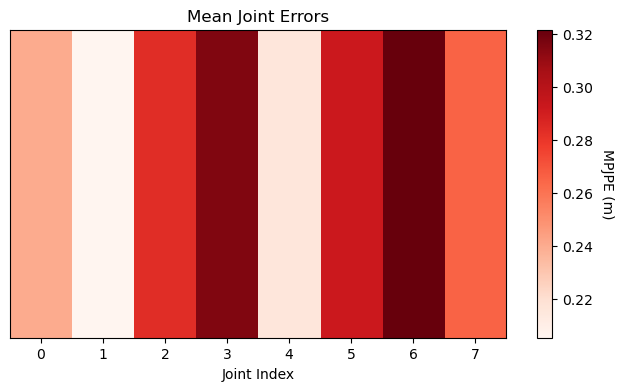

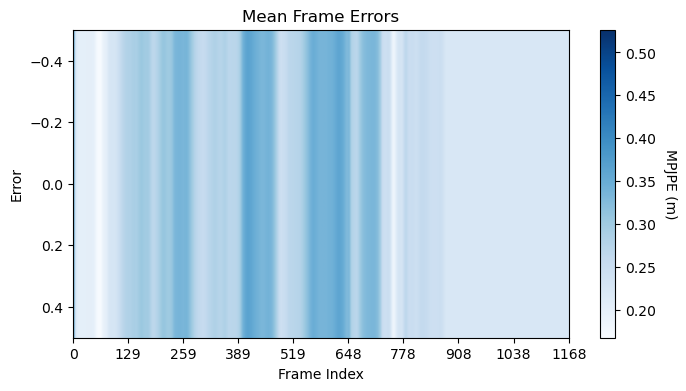

✓ Heat-maps saved in ./result/


In [27]:
#!/usr/bin/env python3
# ──────────────────────────────────────────────────────────
#  Inference + Error-heatmap visualisation for IMU→Skeleton
# ──────────────────────────────────────────────────────────
import os, glob, numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ───────────────────────── Dataset & helpers ─────────────
def extractMoCap(data):
    time = data['time']                               # (T,)
    torso = np.stack([np.zeros_like(data['leftShoulderPosRel']),
                      data['leftShoulderPosRel'],
                      data['rightShoulderPosRel'],
                      np.zeros_like(data['rightShoulderPosRel'])], axis=1)
    left_arm  = np.stack([data['leftShoulderPosRel'],
                          data['leftElbowPosRel'],
                          data['leftWristPosRel'],
                          data['leftFingerPosRel']], axis=1)
    right_arm = np.stack([data['rightShoulderPosRel'],
                          data['rightElbowPosRel'],
                          data['rightWristPosRel'],
                          data['rightFingerPosRel']], axis=1)
    return time, torso, left_arm, right_arm            # time, (T,4,3), (T,4,3), (T,4,3)

def extractIMU(data):
    time = data['time']
    return (time,
            data['accelerationLeftLoc'],  data['accelerationRightLoc'],
            data['gyroLeftLoc'],          data['gyroRightLoc'])

class CustomDataset(Dataset):
    def __init__(self, filenames): self.fnames = filenames
    def __len__(self): return len(self.fnames)
    def __getitem__(self, idx):
        f = self.fnames[idx]
        d = np.load(f)
        time, torso, left_arm, right_arm = extractMoCap(d)
        _, l_acc, r_acc, l_gyro, r_gyro  = extractIMU(d)
        mocap = np.concatenate([left_arm, right_arm], axis=1)          # (T, 8, 3)
        imu   = np.stack([l_acc, r_acc, l_gyro, r_gyro], axis=1)       # (T, 4, 3)
        return {'time': torch.tensor(time,   dtype=torch.float32),
                'mocap':torch.tensor(mocap, dtype=torch.float32),
                'imu':  torch.tensor(imu,   dtype=torch.float32)}

def collate_fn(batch):
    max_len = max(len(x['time']) for x in batch)
    def pad(seq, tgt_len, pad_last):
        pad_len = tgt_len - len(seq)
        return torch.cat([seq, pad_last.repeat(pad_len,1,1)])
    out = {'mocap':[], 'imu':[], 'time':batch[0]['time'][:max_len]}
    for s in batch:
        out['mocap'].append(pad(s['mocap'], max_len, s['mocap'][-1:]))
        acc  = pad(s['imu'][:,[0,1]], max_len, s['imu'][-1:,[0,1]])
        gyro = pad(s['imu'][:,[2,3]], max_len,
                   torch.zeros_like(s['imu'][-1:,[2,3]]))
        out['imu'].append(torch.cat([acc, gyro], dim=1))
    out['mocap'] = torch.stack(out['mocap'])           # (B,T,8,3)
    out['imu']   = torch.stack(out['imu'])             # (B,T,4,3)
    return out

# ───────────────────────── Model ─────────────────────────
class SimpleNN(nn.Module):
    def __init__(self, input_size=4*3, hidden_size=8*3, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
    def forward(self, x):                     # (B,T,4,3)
        x = x.flatten(2)                      # (B,T,12)
        out, _ = self.lstm(x)                  # (B,T,24)
        return out


# ───────────────────────── Heat-maps ─────────────────────
def plot_joint_error_heatmap(pred, gt, path=None):
    errs = np.linalg.norm(pred-gt, axis=-1)    # (T,J)
    fig,ax=plt.subplots(figsize=(8,4))
    im = ax.imshow(errs.mean(0)[None,:], cmap='Reds', aspect='auto')
    ax.set_xlabel('Joint Index'); ax.set_yticks([]); ax.set_title('Mean Joint Errors')
    cbar=plt.colorbar(im,ax=ax); cbar.set_label('MPJPE (m)',rotation=270,labelpad=15)
    if path: os.makedirs(os.path.dirname(path),exist_ok=True); plt.savefig(path,dpi=300,bbox_inches='tight')
    plt.show()

def plot_frame_error_heatmap(pred, gt, path=None):
    errs = np.linalg.norm(pred-gt, axis=-1)    # (T,J)
    fig,ax=plt.subplots(figsize=(8,4))
    im = ax.imshow(errs.mean(1)[:,None].T,cmap='Blues',aspect='auto')
    ax.set_xticks(np.linspace(0,len(errs)-1,10,dtype=int))
    ax.set_xlabel('Frame Index'); ax.set_ylabel('Error'); ax.set_title('Mean Frame Errors')
    cbar=plt.colorbar(im,ax=ax); cbar.set_label('MPJPE (m)',rotation=270,labelpad=15)
    if path: os.makedirs(os.path.dirname(path),exist_ok=True); plt.savefig(path,dpi=300,bbox_inches='tight')
    plt.show()

# ───────────────────────── Main ──────────────────────────
def main():
    # -------- data --------
    npz_dir   = '../data'                     # TODO: update if needed
    fnames    = glob.glob(f'{npz_dir}/*.npz')
    assert fnames, f'No .npz files in {npz_dir}'
    subjects  = np.unique([f.split('_')[-2] for f in fnames])
    np.random.seed(42)
    perm      = np.random.permutation(len(subjects))
    test_sub  = subjects[perm[-1:]]
    test_set  = CustomDataset([f for f in fnames if f.split('_')[-2] in test_sub])
    test_dl   = DataLoader(test_set, batch_size=10, collate_fn=collate_fn)

    # -------- model & ckpt --------
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model  = SimpleNN().to(device)
    ckpt   = './LSTM_epoch_1.pth'             # TODO: checkpoint path
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

    # -------- inference on one batch --------
    batch   = next(iter(test_dl))
    imu_in  = batch['imu'].to(device)         # (B,T,4,3)
    gt_full = batch['mocap']                  # (B,T,8,3) still on CPU
    with torch.no_grad():
        out = model(imu_in).cpu()         # (B, T, 24)
        pred_full = out.view(out.size(0), out.size(1), 8, 3)  # (B, T, 8, 3)


    # -------- choose first sequence & visualise --------
    pred = pred_full[0].numpy()               # (T,8,3)
    gt   = gt_full[0].numpy()
    plot_joint_error_heatmap(pred, gt, './result/joint_error_heatmap.png')
    plot_frame_error_heatmap(pred, gt, './result/frame_error_heatmap.png')
    print('✓ Heat-maps saved in ./result/')

if __name__ == '__main__':
    main()
